In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import keras
keras.__version__

'2.15.0'

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Cargar el modelo VGG16 preentrenado
model = VGG19(weights='imagenet')

# Cargar una imagen de ejemplo y preprocesarla
image_path = 'Nami_op.jpg'
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Realizar la prediccion
predictions = model.predict(img_array)

# Decodificar y mostrar los resultados
decoded_predictions = decode_predictions(predictions, top=3)[0]




35363/35363 [==============================] - 0s 1us/step


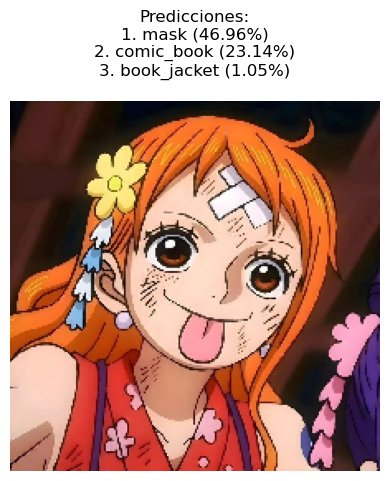

In [2]:
# Visualizar la imagen y las predicciones
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes

# Título con las predicciones
title = "Predicciones:\n"
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    title += f"{i+1}. {label} ({score*100:.2f}%)\n"

plt.title(title)
plt.show()

In [3]:
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image

# La imagen que adoptará el estilo
target_image_path = "gato.jpg"

img = Image.open(target_image_path)
img_width, img_height = img.size

# La imagen que dará el estilo
style_reference_image_path = "Estilo.jpg"

# Dimensiones de la imagen generada
width, height = load_img(target_image_path).size
img_height = img_height
img_width = img_width

In [4]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR -> RGB
    x = np.clip(x, 0, 225).astype("float64")
    return x

In [5]:
from keras import backend as k

target_image = k.constant(preprocess_image(target_image_path))
style_reference_image = k.constant(preprocess_image(style_reference_image_path))

# Este marcador de posición contendrá nuestra imagen generada
combination_image = k.placeholder((1, img_height, img_width, 3))

# Combinamos las 3 imagenes en un solo lote
input_tensor = k.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights= "imagenet",
                    include_top=False)
print("Modelo cargado correctamente.")

Modelo cargado correctamente.


In [6]:
def content_loss(base, combination):
    return k.sum(k.square(combination - base))

In [7]:
def gram_matrix(x):
    features = k.batch_flatten(k.permute_dimensions(x, (2,0,1)))
    gram = k.dot(features, k.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return k.sum(k.square(S-C)) / (4. * (channels ** 2) * (size ** 2))

In [8]:
def total_variation_loss(x):
    a = k.square(
        x[:, :img_height -1, :img_width -1, :] - x[:, 1:, :img_width -1, :])
    b = k.square(
        x[:, :img_height -1, :img_width -1, :] - x[:, :img_height -1, 1:, :])
    return k.sum(k.pow(a+b, 1.25))

In [9]:
# Crear un diccionario que asocia nombres de capas con sus salidas
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Nombre de la capa usada para la pérdida de contenido
content_layer = "block5_conv2"

# Nombre de las capas usadas para la pérdida de estilo
style_layers = ["block1_conv1",
                "block2_conv1",
                "block3_conv1",
                "block4_conv1",
                "block5_conv1"]

# Pesos para las diferentes pérdidas en el cálculo total
total_variation_weight = 1e-4  # Peso para la pérdida de variación total
style_weight = 1.0             # Peso para la pérdida de estilo
content_weight = 0.025         # Peso para la pérdida de contenido

# Inicializar la variable de pérdida total
loss = k.variable(0.0)

# Extraer características de la capa de contenido
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]   # Características de la imagen objetivo
combination_features = layer_features[2, :, :, :]    # Características de la imagen combinada
loss = loss + content_weight * content_loss(target_image_features, combination_features)  # Añadir la pérdida de contenido a la pérdida total

# Calcular y añadir la pérdida de estilo para cada capa de estilo
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]  # Características de la imagen de referencia de estilo
    combination_features = layer_features[2, :, :, :]      # Características de la imagen combinada
    sl = style_loss(style_reference_features, combination_features)  # Calcular la pérdida de estilo
    loss += (style_weight / len(style_layers)) * sl        # Añadir la pérdida de estilo ponderada a la pérdida total

# Añadir la pérdida de variación total a la pérdida total
loss += total_variation_weight * total_variation_loss(combination_image)


In [10]:
import tensorflow as tf

# Función para calcular la pérdida y los gradientes
@tf.function
def compute_loss_and_grads(image):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = total_variation_weight * total_variation_loss(image)
    grads = tape.gradient(loss, image)
    return loss, grads

# Clase Evaluator para evaluar la pérdida y los gradientes
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    # Método para calcular la pérdida
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        x_tensor = tf.convert_to_tensor(x)
        loss_value, grad_values = compute_loss_and_grads(x_tensor)
        self.loss_value = loss_value.numpy()
        self.grad_values = grad_values.numpy().flatten().astype("float64")
        return self.loss_value

    # Método para obtener los gradientes
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# Dimensiones de la imagen
img_height = 400
img_width = 1846

# Instancia de la clase Evaluator
evaluator = Evaluator()

In [11]:
from scipy.optimize import fmin_l_bfgs_b
import time
import imageio

# Prefijo para los nombres de los archivos de resultado
result_prefix = "style_transfer_result"
# Número de iteraciones de optimización
iterations = 10

# Preprocesar la imagen de destino
x = preprocess_image(target_image_path)
# Aplanar la imagen preprocesada para la optimización
x = x.flatten()
# Bucle para realizar las iteraciones de optimización
for i in range(iterations):
    print("Inicio de iteraciones", i)
    start_time = time.time()  # Registrar el tiempo de inicio
    # Ejecutar la optimización L-BFGS-B
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                      fprime=evaluator.grads, maxfun=20)
    print("Valos de perdida actual:", min_val)

    # Copiar y remodelar la imagen optimizada
    img = x.copy().reshape((img_height, img_width, 3))
    # Deshacer el preprocesamiento para obtener la imagen final
    img = deprocess_image(img)
    # Generar el nombre del archivo de resultado
    fname = result_prefix + "_at_iteration_%d.png" % i
    
    # Guardar la imagen resultante
    imageio.imwrite('Imagen generada.png', img)


    end_time = time.time()  # Registrar el tiempo de finalización
    print("Iteración %d completa en %ds" % (i, end_time - start_time))


Inicio de iteraciones 0


Lossy conversion from float64 to uint8. Range [5.6479715538147985, 225.0]. Convert image to uint8 prior to saving to suppress this warning.


Valos de perdida actual: 16798.581819593477
Iteración 0 completa en 50s
Inicio de iteraciones 1


Lossy conversion from float64 to uint8. Range [8.854558625301536, 225.0]. Convert image to uint8 prior to saving to suppress this warning.


Valos de perdida actual: 3837.2582490748346
Iteración 1 completa en 29s
Inicio de iteraciones 2
Valos de perdida actual: 1659.9207378172964


Lossy conversion from float64 to uint8. Range [9.031341608777524, 225.0]. Convert image to uint8 prior to saving to suppress this warning.


Iteración 2 completa en 29s
Inicio de iteraciones 3


Lossy conversion from float64 to uint8. Range [9.467660915877346, 225.0]. Convert image to uint8 prior to saving to suppress this warning.


Valos de perdida actual: 893.1623380873912
Iteración 3 completa en 28s
Inicio de iteraciones 4


Lossy conversion from float64 to uint8. Range [10.659027092196538, 225.0]. Convert image to uint8 prior to saving to suppress this warning.


Valos de perdida actual: 541.337896559444
Iteración 4 completa en 27s
Inicio de iteraciones 5


Lossy conversion from float64 to uint8. Range [11.669977733856541, 225.0]. Convert image to uint8 prior to saving to suppress this warning.


Valos de perdida actual: 382.4766530261215
Iteración 5 completa en 27s
Inicio de iteraciones 6


Lossy conversion from float64 to uint8. Range [12.474213701735934, 225.0]. Convert image to uint8 prior to saving to suppress this warning.


Valos de perdida actual: 287.5230979796815
Iteración 6 completa en 26s
Inicio de iteraciones 7


Lossy conversion from float64 to uint8. Range [13.099059697679039, 225.0]. Convert image to uint8 prior to saving to suppress this warning.


Valos de perdida actual: 232.39695765455483
Iteración 7 completa en 31s
Inicio de iteraciones 8


Lossy conversion from float64 to uint8. Range [13.970930146344443, 222.21136941410526]. Convert image to uint8 prior to saving to suppress this warning.


Valos de perdida actual: 175.0549582712559
Iteración 8 completa en 27s
Inicio de iteraciones 9


Lossy conversion from float64 to uint8. Range [14.57725237791091, 219.84556942886658]. Convert image to uint8 prior to saving to suppress this warning.


Valos de perdida actual: 143.67505751877204
Iteración 9 completa en 26s


In [12]:
img

array([[[112.92480713,  92.09454996,  78.33110161],
        [112.90872923,  92.09828283,  78.38038591],
        [112.75812285,  92.01065367,  78.44800104],
        ...,
        [213.18483706, 169.59611749, 130.78901227],
        [213.2461824 , 169.65152979, 130.85637693],
        [213.32426996, 169.71931245, 130.95376765]],

       [[112.38580749,  91.70177556,  78.3273949 ],
        [112.38243316,  91.70748825,  78.37120918],
        [112.24356619,  91.65443089,  78.41269794],
        ...,
        [213.09559507, 169.52110364, 130.69623248],
        [213.15128094, 169.56979784, 130.74506081],
        [213.21102516, 169.62528047, 130.79075384]],

       [[111.52079946,  91.14214943,  78.22142214],
        [111.48513039,  91.13434629,  78.23096995],
        [111.33923058,  91.06001936,  78.24842775],
        ...,
        [212.95993111, 169.40364341, 130.56008171],
        [213.00328682, 169.44050818, 130.58920787],
        [213.03461887, 169.46411747, 130.59465506]],

       ...,

      

In [13]:
target_image_path

'gato.jpg'